# **Common Prosperity Simulation**
## Computational Physics Lab 
Authors: Yuan-Yen Peng, Chih-Tian Ho  
E-mail: garyphys0915@gapp.nthu.edu.tw, chihtian.ho@gapp.nthu.edu.tw  
Dept of Physics, NTHU, Taiwan   
Date: SOMEDATE  
Version: 2.3.2  
License: MIT

In [1]:
# reset all variables
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path
from numba import jit, njit, prange
import time
from PIL import Image
import glob

### initial conditions

In [2]:
# initial setup
problem_name = 'Common_Prosperity'
io_screen = True
io_freq = 5 # how many steps to record the data
io_title = problem_name

In [3]:
# setup
size = int(50)
width, length = size, size # grid's width and length
N = int(width * length) # how many sites
n = 100 # time steps
tmax = 1000 # [code unit]

# initial energy conditions
J = 10 # configuration constant (positive means paramagnetism)

# initial bkg condition, set the standard diviation for x & y are both 3 
sigma_x, sigma_y = 10.0, 10.0

# intial self condition, set eta, will be adjust by results (absorbing coeff)
eta = 1e-5 # absorbing rate constant

# probability
p = 0.5 # rich --> poor
q = 0.5 # poor --> rich

### Grid generator

In [4]:
def grid_generator(width, length, init_rank:float = 3.0, dec: int = 2):
  '''
  This is a grid generator
  :para width: width of the grid
  :para length: lerngth of the grid
  :para init_rank: bounds of initial rank of the grid; i.e., if use 3, --> [-3, 3]
  :para dec: decimal for the function <round>
  '''

  grid_positive = np.round(init_rank * np.random.random(int(N/2)), dec)
  grid_negative = np.round(-init_rank * np.random.random(int(N/2)), dec)
  grid = np.append(grid_positive, grid_negative)
  np.random.shuffle(grid) # set it to random
  grid = grid.reshape((width, length))

  # add the boundaries to four margins with minimum initial rank - 1
  tor = - (init_rank + 1)
  res = np.array([tor * np.ones(length)])
  grid_boundary = np.concatenate((res, grid, res), axis=0)
  grid_boundary = np.insert(grid_boundary, (0, length), tor, axis=1)

  return grid, grid_boundary

In [5]:
def plot(arr, header, lim, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.colorbar()
  plt.clim(-lim, lim)
  plt.title(f'{header}')

  return

In [6]:
def plot_ct(arr, header, lim, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.75)
  plt.colorbar()
  plt.contour(arr, colors='w', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.clim(-lim, lim)
  plt.title(f'{header}')

  return

### output

make the directories

In [7]:
io_folder_fig = "fig_" + io_title
Path(io_folder_fig).mkdir(parents=True, exist_ok=True)

output figures

In [8]:
def output_fig(n, arr, lim, time, title):
  """
  Write simulation data into a file named "fig"
  """
  header = f"{title}, time = {np.round(time, 3)}"
  plot(arr, header, lim)
  fig = f'{io_folder_fig}/fig_{io_title}_{title}_{str(n).zfill(3)}.png'
  plt.savefig(fig)
  plt.close() # in order to save memory

  return 

### main exchange functions

In [9]:
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary

#### Energy (each time)

In [10]:
@njit(parallel = True) # faster than jit if using "parallel"
def energy(spin, N, J, h):
  '''
  :para spin: is a spin matrix
  :para N: is the total number of sites
  :para J: is configuration constant (positive means paramagnetism)
  :para h: is external field
  '''

  l = int(np.sqrt(N))
  energy = np.zeros((l+2, l+2))
  for i in prange(1, l+1):
    for j in prange(1, l+1):
      s_cen  = spin[i  , j  ]
      s_up   = spin[i-1, j  ]
      s_rig  = spin[i  , j+1]
      s_down = spin[i+1, j  ]
      s_lef  = spin[i  , j-1]

      energy[i, j] = -J * s_up * s_rig * s_down * s_lef - h * s_cen

  return energy

#### Magnetization (each time)

In [11]:
def mag(spin):
  '''
  :para m: magnetization per spin (site)
  :para M: total magnetization
  '''
  
  M = np.sum(spin)
  m = np.average(spin)
  return m, M

#### Background function (each time)

In [12]:
@njit(parallel = True)
def bkg(N, sigma_x, sigma_y):
  '''
  :para N: is the total number of sites
  :para sigma_x: is a standard deviation in x-direction
  :para sigma_y: is a standard deviation in y-direction
  '''

  # l is the length; l_incluse is the length with margins; i.e., +2
  l = int(np.sqrt(N))
  l_include = l + 2
  BKG = np.ones((l_include, l_include))
  for i in prange(l):
        for j in prange(l):
            BKG[i, j] = (np.exp(-((i - l_include/2 + 2 )**2 / (2*sigma_x**2) 
                        + (j - l_include/2 + 2 )**2 / (2*sigma_y**2))))
  return BKG

#### Self (spin) function (each time)

In [13]:
@njit(parallel = True)
def self(N, t, tmax, spin, bkg, eta):
  '''
    :para N: is the total number of sites
    :para t: is the time in the moment
    :para spin: is the spin matrix
    :para bkg: is the background function
    :para eta: absorbing rate constant

    1) set another array called new playground as nspin to save the new Hierarchy, 
       and update when all units are calculated.
    2) note that no need for bkg since they are indep. for each
  '''
  l = int(np.sqrt(N))
  nspin = spin # this is temp of spin (which depend on spin)
  for i in prange(1, l+1):
      for j in prange(1, l+1):

          # setup relative spins positions
          s_cen  = spin[i  , j  ]
          s_up   = spin[i-1, j  ]
          s_rig  = spin[i  , j+1]
          s_down = spin[i+1, j  ]
          s_lef  = spin[i  , j-1]
          
          # temp spin matrix
          nspin[i,j] += ((1 / np.sqrt(2*3**2)) * np.exp(-(s_cen/(2 * 3**2))) * (-(4*s_cen - s_rig -s_lef - s_up - s_down)) 
                        + eta * (np.exp(5)/2 * np.exp(spin[i,j]) 
                                + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(spin[i,j]/(2*3**2)))) * bkg[i,j])
          
          # rich --> poor
          if nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 > 4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= p:
                    nspin[i, j] = -4
                else:
                    nspin[i, j] = 5
          elif nspin[i,j] >= 5 and (s_rig + s_lef + s_up + s_down)/4 <= 4:
                    nspin[i, j] = 5

          # poor --> rich
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 < -4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= q:
                    nspin[i, j] = 4
                else:
                    nspin[i, j] = -5    
          elif nspin[i,j] <= -5 and (s_rig + s_lef + s_up + s_down)/4 >= -4:
                    nspin[i, j] = -5
          # site max and min is +5 and -5

          # bkg is only decay with the time (add the cos finction with the period t_max)
          bkg[i,j] += np.cos(2 * np.pi * t/tmax) * (- eta * (np.exp(5)/2 * np.exp(s_cen) 
                               + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(s_cen/(2*3**2)))) * bkg[i,j])
          
          # if the average of the "cross" is above the center spin, bkg has negtive influence
          ss = np.array([s_cen, s_up, s_rig, s_down, s_lef])
          if np.average(ss) > s_cen and np.cos(2 * np.pi * t/tmax) >= 0:
            bkg[i,j] = -bkg[i,j]
            print("change")
          

  spin = nspin # temp of spin = new spin (the next next matrix)
  
  return spin

### Main loop

In [14]:
# main (loop of time)
def main(N, n, tmax, spin, J, sigma_x, sigma_y, eta):
    '''
    This is the main loop function, and it will also output the figures(.png).

    :para N: is the total number of sites
    :para n: is total number of time steps
    :para T: is the total time
    :para spin: is the spin matrix
    :para J: is configuration constant (positive means paramagnetism)
    :para sigma_x: is a standard deviation in x-direction
    :para sigma_y: is a standard deviation in y-direction
    :para eta: absorbing rate constant
    '''

    dt = tmax / n
    t = 0
    temp_n = 0
    
    # initial setup checking 
    h = 0 # set no bkg influences in the beginning
    Ei =energy(spin, N, J, h)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)
    m = np.array([mag(Si)[0]])
    M = np.array([mag(Si)[1]])
    
    # initial output
    clim_spin = np.max(np.abs(Si))
    clim_energy = np.max(np.abs(Ei))
    output_fig(temp_n, Si, clim_spin, t, "spin")
    output_fig(temp_n, Ei, clim_energy, t, "energy")
    print("Initial t = 0, succeed to output!")

    t1 = time.time()
    while t < tmax:
      # update data
      bk = bkg(N, sigma_x, sigma_y)
      h = 0.2 * np.average(bk)
      epsilon =energy(spin, N, J, h)
      spin = self(N, t, tmax, spin, bk, eta)
      
      # prune margins
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      m = np.append(mag(S)[0], m)
      M = np.append(mag(S)[1], M)
      
      # output files
      if (temp_n % io_freq == 0):
        if io_screen:
            '''
            output info files

            '''
            output_fig(temp_n+1, S, clim_spin, t+dt, "spin")
            output_fig(temp_n+1, E, clim_energy, t+dt, "energy")
            print(f"{temp_n}, t = {np.round(t+dt, 2)}, succeed to output!")

      # update time and steps
      temp_n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t

        # plot the last figure with "contour"
        plot_ct(S, f"spin, t = {np.round(t, 2)}", clim_spin, size = 8, dpi = 80)
        plot_ct(E, f"energy, t = {np.round(t, 2)}", clim_energy, size = 8, dpi = 80)
    t2 = time.time()
    
    # output magnetization
    T = np.linspace(0, tmax, temp_n+1)
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('m [code unit]')
    plt.title(f'Magnetization per spin with {size}')
    plt.plot(T, m, '--o', alpha = .6)
    plt.show()
    
    figure(figsize=(9, 6), dpi=80)
    plt.xlabel('time [code unit]')
    plt.ylabel('M [code unit]')
    plt.title(f'Magnetization with {size}')
    plt.plot(T, M, '--o', alpha = .6)
    plt.show()
    
    return print("Done! Time = ", np.round(t2 - t1, 3), "[s]")

### Execution

串流輸出內容已截斷至最後 5000 行。
change
change
change
change
change
change
change
change
change
change
change
change
change
changechange
change

change
change
change
change
changechange
change

change
changechange
change

change
change
change
changechange

change
change
change
change
change
changechange

change
change
change
change
changechange
change

change
changechange
change

change
change
change
change
change
change
change
change
change
change
change
changechange
change

changechange
change

changechange
change

change
changechange

change
change
changechange
change

change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change
change

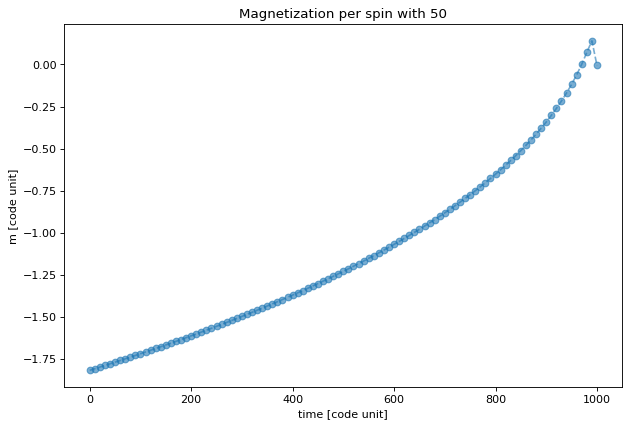

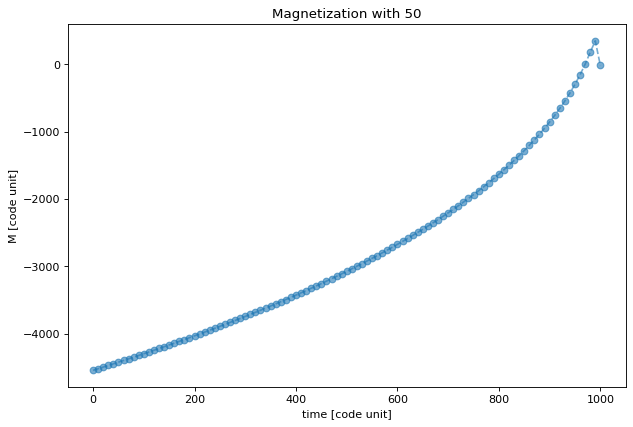

Done! Time =  35.074 [s]
Taking 38.9 [s]
Finish!


In [15]:
t1 = time.time()
main(N, n, tmax, spin, J, sigma_x, sigma_y, eta)
t2 = time.time()

print(f"Taking {np.round((t2 - t1), 3)} [s]")
print("Finish!")

### Creat GIF

In [16]:
'''
Energy
'''

# Create the frames
frames = []
imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_energy_*.png")
imgs.sort()
# check the sorted result
print(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('energy.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=500, loop=0)

print("Done!")

['fig_Common_Prosperity/fig_Common_Prosperity_energy_000.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_001.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_006.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_011.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_016.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_021.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_026.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_031.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_036.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_041.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_046.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_051.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_056.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_061.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_066.png', 'fig_Common_Prosperity/fig_Common_Prosperity_energy_071.png', 'fig_Co

In [17]:
'''
Spin
'''

# Create the frames
frames = []
imgs = glob.glob(f"{io_folder_fig}/fig_Common_Prosperity_spin_*.png")
imgs.sort()
# check the sorted result
print(imgs)

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('spin.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=500, loop=0)

print("Done!")

['fig_Common_Prosperity/fig_Common_Prosperity_spin_000.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_001.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_006.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_011.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_016.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_021.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_026.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_031.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_036.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_041.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_046.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_051.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_056.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_061.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_066.png', 'fig_Common_Prosperity/fig_Common_Prosperity_spin_071.png', 'fig_Common_Prosperity/fig_Common_Prosp